# Data Exploration

In [1]:
from DevelopedMethods.DF import *  # import np, pd, sklearn fn's --and df (https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data)

In [2]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


**notice <u>all numerical</u> features:**

**binary:** *smoking, sex, high_blood_pressure, diabetes, anaemia*

**non-binary:** *age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium*

**About The Dataset**:
"This set is not to predict CHF but rather to see which other factors may be related to patients who, in a given time frame, went on to have a Myocardial infarction event."

*Serum* = concentration levels of protein-rich liquid that separates out when blood coagulates (electrolytes, proteins, enzymes, etc.)
- **serum_creatinine:** levels of creatinine in the serum. >> indicates kidney damage. waste product of muscle metabolism.
- **creatinine_phosphokinase:** levels of important muscle & heart tissue enzyme (released when there's damage).
- **ejection_fraction:** measures efficiency of the heart (how much blood is a ejected)
- **platelets:** cell-fragments found in blood. form clots / stop you from bleeding.


## Feature Matrix (X) & Target/label Vector (y)

In [3]:
df = df.drop(columns=['time']) # (future) event time (generated along w/ DEATH_EVENT) (or study length, study WILL end abrubtly from either LIVING & ending reporting, or DYING from 'Myocardial Infarction Event')
X = df.iloc[:, :-1]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [4]:
stages = dict(DF=X, y=y, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test) # make running code / plotting stages easier

## Check For Imbalance

In [5]:
tmp = pd.concat([y.value_counts(), y.value_counts(normalize=True) * 100, pd.Series(["||", "||"]), y_train.value_counts(), y_train.value_counts(normalize=True) * 100], axis=1)
tmp.columns = ['y', f'({len(y)} samples)    %', '||', 'y_train', f'({len(y_train)} samples)   %']
print(tmp)

     y  (299 samples)    %  ||  y_train  (239 samples)   %
0  203           67.892977  ||      160          66.945607
1   96           32.107023  ||       79          33.054393


## Mild imbalance. Explore SMOTE, weighted loss functions, or threshold tuning.
1. **SMOTE (Synthetic Minority Over-sampling Technique):** This technique generates synthetic samples for the minority class (DEATH_EVENT) to balance the dataset. It's effective but can introduce noise.
1. **Weighted Loss Functions:** higher weights to minority class **during training**. This approach helps the model focus more on correctly predicting the minority class without altering the dataset.
1. **Threshold Tuning:** Adjust the decision threshold of your model's predictions to improve sensitivity for the minority class. This is useful **after model training**.

In [6]:
smote = SMOTE(random_state=55)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"X_train ({len(X_train)}) => X_train_resampled ({len(X_train_resampled)})\n\n", y_train_resampled.value_counts())

X_train (239) => X_train_resampled (320)

 DEATH_EVENT
0    160
1    160
Name: count, dtype: int64


In [7]:
stages.update(dict(X_train_resampled=X_train_resampled, y_train_resampled=y_train_resampled))

**Detect SMOTE Noise:** PCA - SMOTE Original vs Synthetic Samples

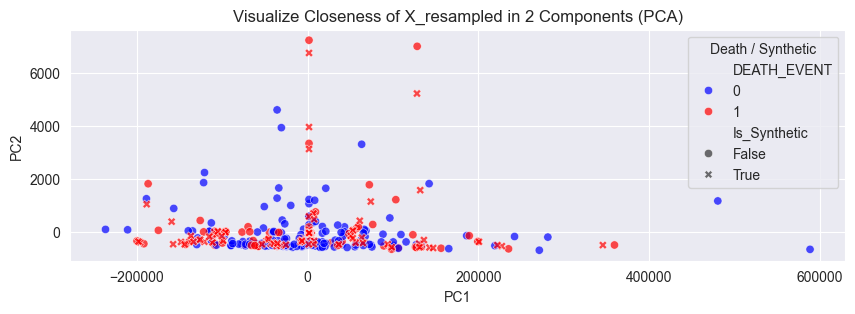

In [8]:
pca = PCA(n_components=2, random_state=55) # apply PCA to reduce 2D (2 features) —for visualization
X_resampled_pca = pca.fit_transform(X_train_resampled)

plot_df = pd.DataFrame(X_resampled_pca, columns=["PC1", "PC2"])
plot_df["DEATH_EVENT"] = y_train_resampled
plot_df["Is_Synthetic"] = np.array([False]*len(X_train) + [True]*(len(X_train_resampled) - len(X_train))) # [...original, ...synthetic] (SMOTE adds synthetic samples @ end)

plt.figure(figsize=(10, 3))
sns.scatterplot(
    data=plot_df,
    x="PC1", y="PC2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("Visualize Closeness of X_resampled in 2 Components (PCA)")
plt.legend(title="Death / Synthetic")
plt.show()


Blue circles = majority class original

Red circles = minority class original

Red X’s = synthetic samples added by SMOTE

... No outliers => no noise found. &nbsp; ie: &nbsp; X's (synthetic) are all near red circles (original's from minority class)

**Detect SMOTE Noise (2):**

**<u>t-SNE</u>** (t-Distributed Stochastic Neighbor Embedding) ...to inspect tighter clusters ——better than PCA at preserving local structure

**more info:** converts the distances between points into probabilities -> 2d. then reduces the "crowding problem" with "Student's t-Distribution". iteratively minimizes divergence between 2d and n-dimension probability distributions.

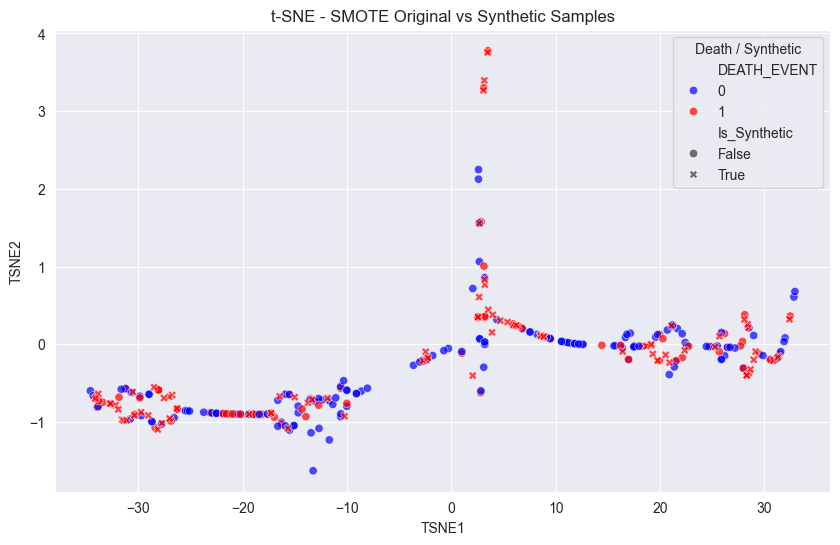

In [9]:
tsne = TSNE(n_components=2, random_state=55, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_train_resampled)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["DEATH_EVENT"] = y_train_resampled
tsne_df["Is_Synthetic"] = plot_df["Is_Synthetic"] # [...original, ...synthetic]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x="TSNE1", y="TSNE2",
    hue="DEATH_EVENT",
    style="Is_Synthetic",
    palette={0: "blue", 1: "red"},
    markers={False: "o", True: "X"},
    alpha=0.7
)
plt.title("t-SNE - SMOTE Original vs Synthetic Samples")
plt.legend(title="Death / Synthetic")
plt.show()


we see the same (but with a better view) &nbsp; ——synthetic samples all very close to original samples

# ModelMetrics(): Fit (on _train) + Predict (on _test) + Score (<u>types:</u> accuracy_score, Cross Validation (CV), F1 CV, ROC CV)

In [10]:
f1_scorer = metrics.make_scorer(metrics.f1_score)
class ModelMetrics(): # notice: we are doing CV w/ train_test_split... only AUC seems to fluctuate w/o
    def __init__(self, algo, X_train, X_test, y_train, y_test, model_specific={}):
        self.model = algo
        self.is_sequential = (algo.__class__.__name__ == "Sequential")

        if self.is_sequential:
            algo.compile(**model_specific["compile"])
            self.history = algo.fit(X_train, y_train, **model_specific["fit"])
            raw_preds = algo.predict(X_test)
            self.predictions = (raw_preds > 0.5).astype("int32")
        else:
            algo.fit(X_train, y_train)
            self.predictions = algo.predict(X_test)

        self.acc = metrics.accuracy_score(y_test, self.predictions)

        # cross validation
        if self.is_sequential:
            print("⚠️ Skipping cross-validation for Sequential model (retraining would occur).")
            self.cv_mean = None
            self.f1 = None
        else:
            self.cv = cross_val_score(algo, X_train, y_train, cv=10)
            self.cv_mean = self.cv.mean()

            self.f1_cv = cross_val_score(algo, X_train, y_train, cv=10, scoring=f1_scorer)
            self.f1 = self.f1_cv.mean()

        # ROC AUC
        if algo.__class__.__name__ in ["KMeans"]: # unsupervised/no predict_proba
            self.roc_AUC = None
            return

        if algo.__class__.__name__ == "SVC":
            y_scores = algo.decision_function(X_test)
        elif self.is_sequential:
            y_scores = raw_preds
        else:
            y_scores = algo.predict_proba(X_test)[:,1]

        roc_fpr, roc_tpr, roc_thresholds = metrics.roc_curve(y_test, y_scores)
        self.roc_fpr = roc_fpr
        self.roc_tpr = roc_tpr
        self.roc_thresholds = roc_thresholds
        self.roc_AUC = metrics.roc_auc_score(y_test, y_scores)

    def __repr__(self):
        return f"""\n        acc: {self.acc}
        cv_mean: {self.cv_mean}
        f1: {self.f1}
        roc_AUC: {self.roc_AUC}"""

# Feature Importance Analysis

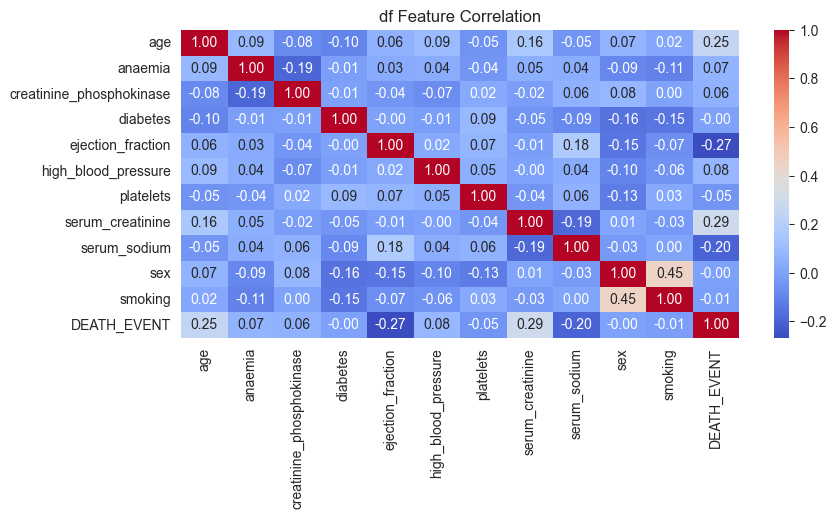

In [11]:
plt.figure(figsize=(9, 4))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('df Feature Correlation')
plt.show()

### Decision Tree

In [12]:
decisiontree = DecisionTreeClassifier(random_state=55) # invariant to feature scaling
decisiontree_resampled = DecisionTreeClassifier(random_state=55)
models = dict(decisiontree=ModelMetrics(decisiontree, X_train, X_test, y_train, y_test),
     decisiontree_resampled=ModelMetrics(decisiontree_resampled, X_train_resampled, X_test, y_train_resampled, y_test))
models

{'decisiontree': 
         acc: 0.6833333333333333
         cv_mean: 0.6655797101449274
         f1: 0.46938034188034183
         roc_AUC: 0.6012311901504787,
 'decisiontree_resampled': 
         acc: 0.6666666666666666
         cv_mean: 0.7125
         f1: 0.7072444531120838
         roc_AUC: 0.5896032831737346}

#### Decision Tree — Feature Importance Analysis

In [13]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': decisiontree_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,serum_creatinine,27.976344,,,serum_creatinine,27.158690
2,platelets,20.023063,,,ejection_fraction,17.391362
3,ejection_fraction,17.051321,,,serum_sodium,15.552510
4,age,11.752735,,,creatinine_phosphokinase,14.456821
5,creatinine_phosphokinase,10.709853,,,platelets,11.167325
6,serum_sodium,8.705038,,,age,7.375782
7,sex,2.363528,,,sex,2.306164
8,smoking,1.418117,,,smoking,1.778846
9,anaemia,0.000000,,,anaemia,1.770833
10,diabetes,0.000000,,,high_blood_pressure,1.041667


most notable importance fluctuations: &nbsp; ejection_fraction ± 4.5%, &nbsp; age ± 3%

### Random Forest

In [14]:
randomforest = RandomForestClassifier(random_state=55, bootstrap=True, n_estimators=25) # invariant to feature scaling
randomforest_resampled = RandomForestClassifier(random_state=55, bootstrap=True, n_estimators=69)

# """Grid Search (Best n_estimators  between: [1-100, 101-500 (step 5))]"""
# rf = RandomForestClassifier(random_state=55) # grid search for best F1 n_estimators (X_train & X_train_resampled)
# grid = GridSearchCV(estimator=rf, param_grid={'n_estimators': list(range(1, 100)) + list(range(101, 500, 5))}, cv=5, scoring='f1', n_jobs=-1)
# grid.fit(X_train, y_train)
# print(f"Best n_estimators for X_train: {grid.best_params_['n_estimators']}")
# grid.fit(X_train_resampled, y_train_resampled)
# print(f"Best n_estimators for X_train_resampled: {grid.best_params_['n_estimators']}")

new_models = dict(randomforest=ModelMetrics(randomforest, X_train, X_test, y_train, y_test),
        randomforest_resampled=ModelMetrics(randomforest_resampled, X_train_resampled, X_test, y_train_resampled, y_test))
models.update(new_models)
new_models

{'randomforest': 
         acc: 0.7166666666666667
         cv_mean: 0.7536231884057971
         f1: 0.578076923076923
         roc_AUC: 0.7400820793433652,
 'randomforest_resampled': 
         acc: 0.7166666666666667
         cv_mean: 0.815625
         f1: 0.8169773531422138
         roc_AUC: 0.7585499316005472}

#### Random Forest — Feature Importance Analysis

In [15]:
tmp1 = pd.DataFrame({'feature': X.columns, 'importance': randomforest.feature_importances_ * 100})
tmp1 = tmp1.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp2 = pd.DataFrame({'feature': X.columns, 'importance': randomforest_resampled.feature_importances_ * 100})
tmp2 = tmp2.sort_values(by='importance', ascending=False).reset_index(drop=True)
tmp = pd.DataFrame({
    'best_ft': tmp1['feature'],
    'importance %': tmp1['importance'],
    '': pd.Series([""] * len(X.columns)), '&nbsp;': pd.Series([""] * len(X.columns)), # separator/padding cols
    'best_ft_resampled': tmp2['feature'],
    'importance % resampled': tmp2['importance'],
})
tmp.index += 1 # indexing starts @ 1
tmp

,best_ft,importance %,,&nbsp;,best_ft_resampled,importance % resampled
1,serum_creatinine,21.863303,,,serum_creatinine,24.140932
2,ejection_fraction,16.279217,,,ejection_fraction,17.680620
3,age,15.091571,,,age,13.139497
4,serum_sodium,12.298981,,,creatinine_phosphokinase,12.507009
5,platelets,11.894348,,,platelets,11.102209
6,creatinine_phosphokinase,11.278206,,,serum_sodium,10.854332
7,smoking,2.775716,,,sex,3.317297
8,diabetes,2.574449,,,smoking,2.110542
9,sex,2.194040,,,diabetes,1.846204
10,anaemia,2.052310,,,high_blood_pressure,1.680442


no huge fluctuations (little noise), but confirms most of decision tree: (ie: 1: time, 2: serum_creatinine, 3: ¿ejection_fraction?/creatinine_phosphokinase, platelets/age, serum_sodium, ...)

# Choosing a Scaler Function:

Inspect Gaussian Distribution (of values) across stages: (ie: X, X_train, X_train_resampled)

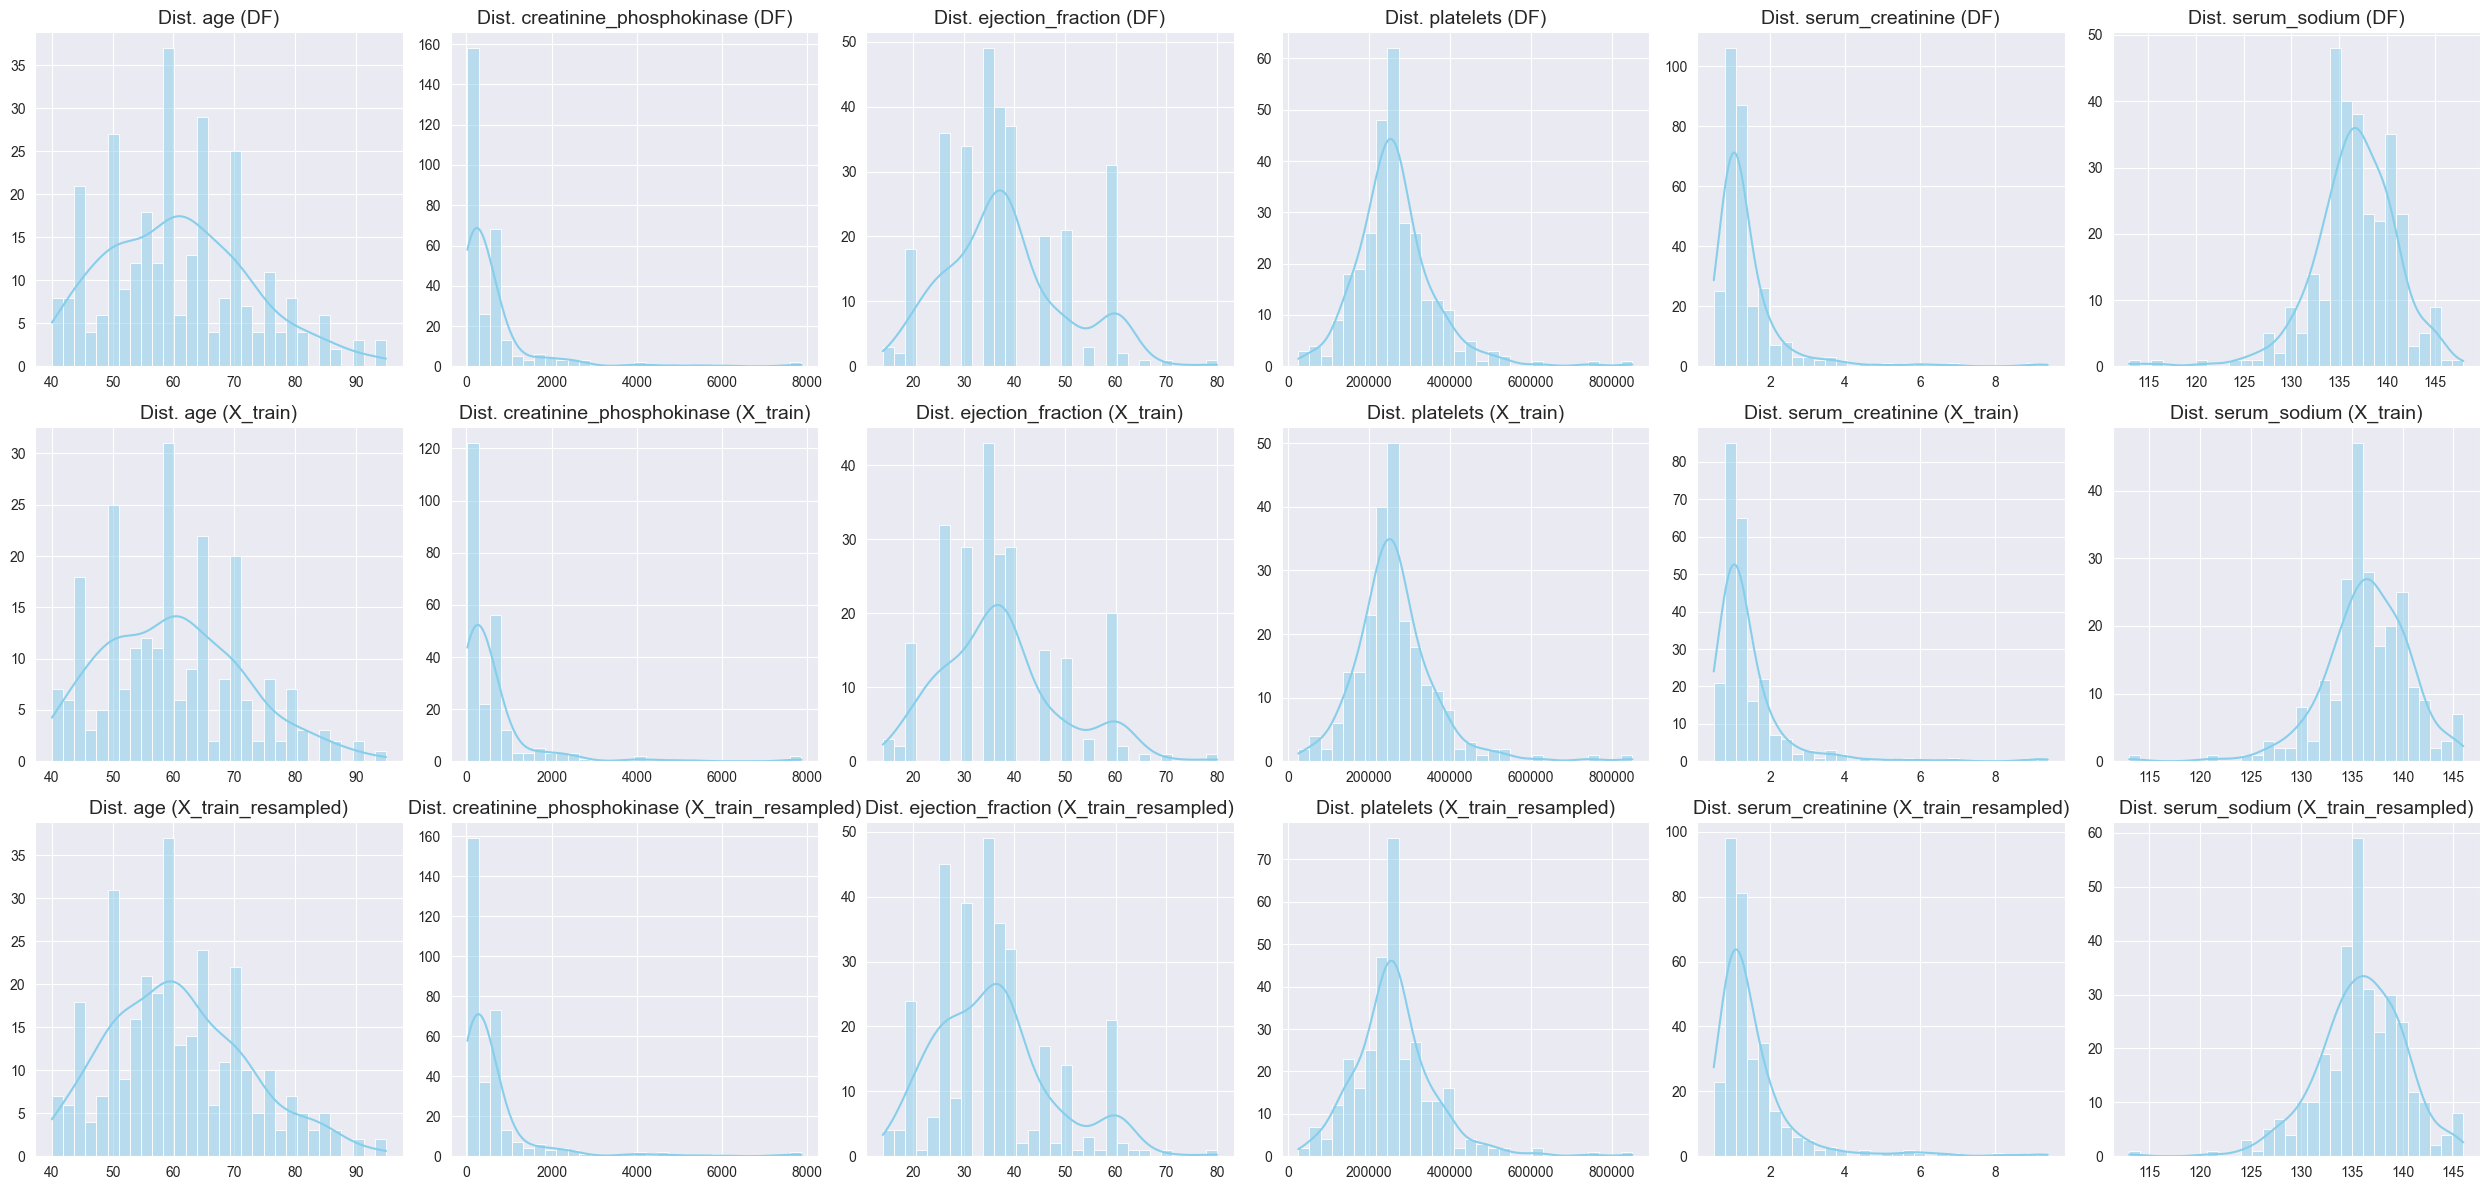

In [16]:
non_binary_features = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium"]
_stages = dict()
for i in stages:
    if i.startswith("y") or i.find("_test") != -1: continue
    _stages[i] = stages[i]
rows = len(_stages) # 3
cols = len(non_binary_features)
plt.figure(figsize=(25, 12))
for i, df_key in enumerate(_stages.keys()):
    for j, feature in enumerate(non_binary_features):
        plot_no = i * cols + j + 1
        plt.subplot(rows, cols, plot_no) # focus plot_no in rowsXcols super-plot
        sns.histplot(_stages[df_key][feature], kde=True, bins=30, color='skyblue') # draw plot histogram w/ KDE "Kernel Density Estimate" (curve)
        plt.title(f"Dist. {feature} ({df_key})", fontsize=14)
        plt.xlabel(None)
        plt.ylabel(None)
plt.tight_layout()
plt.show()

These are the counts of the popularity of each non-binary feature-values in the dataset. (ie: age: 60 is the most common in the dataset (see: the tallest bar/pile))

If Gaussian, KDE curve resembles a bell shape centered around the mean... Kernel Density Estimate/KDE curve is a smoothed approximation of feature-value distribution –like a continuous version of histogram)

**Observations**: &nbsp; Gaussian w/ few peaks; &nbsp; using SMOTE/resampled leads to following Gaussian curve more closely

=> use StandardScaler (Z-score normalization)


## Normalize/Scale

In [17]:
scaler = StandardScaler() # mean=0, standard deviation=1
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

minmax_scaler = MinMaxScaler() # values range [0,...,1]      **——note:** ANN often benefits from MinMaxScaler &nbsp; &nbsp;(likewise for SVM w/ StandardScaler)
X_train_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test_minmax = pd.DataFrame(minmax_scaler.transform(X_test), columns=X.columns, index=X_test.index)
X_train_resampled_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train_resampled), columns=X.columns, index=X_train_resampled.index)

In [18]:
stages.update(dict(X_train_scaled=X_train_scaled, X_test_scaled=X_test_scaled, X_train_resampled_scaled=X_train_resampled_scaled, X_train_minmax=X_train_minmax, X_test_minmax=X_test_minmax, X_train_resampled_minmax=X_train_resampled_minmax))

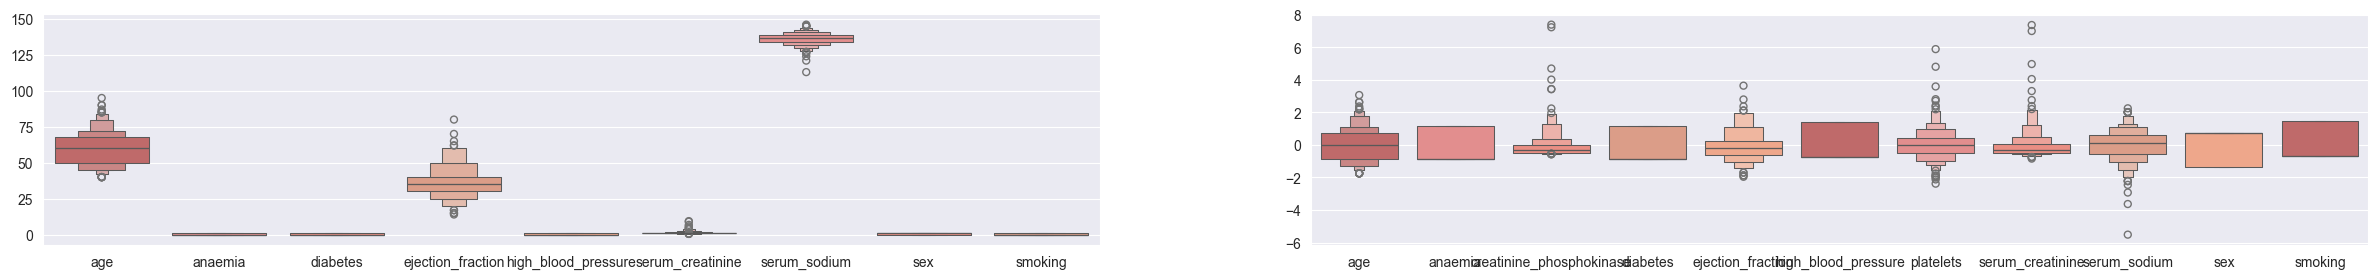

In [19]:
# boxen plots to show affects of normalization
colors = ["#CD5C5C","#F08080","#FA8072","#E9967A","#FFA07A", "#CD5C5C","#F08080","#FA8072","#E9967A","#FFA07A", "#CD5C5C"]
fig, axes = plt.subplots(1, 2, figsize=(30, 3))  # 1 row, 2 columns
sns.boxenplot(ax=axes[0], data=X_train.drop(columns='platelets').drop(columns='creatinine_phosphokinase'), palette=colors[0:9]) # these two don't allow for a good visual (large range makes other smaller ranges invisible)
sns.boxenplot(data = X_train_scaled,palette = colors)
plt.show()

# Begin Classification Problem [0, 1] — Heart Failure Detection
Try traditional algorithms on: X_train, X_train_scaled, X_train_resampled, X_train_resampled_scaled

Logistic Regression

In [20]:
# scaling improves gradient descent/convergence speed (and won't need 'max_iter' increase)
logisticregression = linear_model.LogisticRegression(random_state=55, max_iter=2000)
logisticregression_scaled = linear_model.LogisticRegression(random_state=55)
logisticregression_resampled = linear_model.LogisticRegression(random_state=55, max_iter=4000)
logisticregression_resampled_scaled = linear_model.LogisticRegression(random_state=55)
new_models = dict(logisticregression=ModelMetrics(logisticregression, X_train, X_test, y_train, y_test),
        logisticregression_scaled=ModelMetrics(logisticregression_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     logisticregression_resampled=ModelMetrics(logisticregression_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
logisticregression_resampled_scaled=ModelMetrics(logisticregression_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'logisticregression': 
         acc: 0.7166666666666667
         cv_mean: 0.7534420289855073
         f1: 0.5463318544200898
         roc_AUC: 0.7578659370725035,
 'logisticregression_scaled': 
         acc: 0.75
         cv_mean: 0.7326086956521739
         f1: 0.5062803209862033
         roc_AUC: 0.7633378932968536,
 'logisticregression_resampled': 
         acc: 0.7333333333333333
         cv_mean: 0.7625
         f1: 0.7609816018497233
         roc_AUC: 0.7113543091655267,
 'logisticregression_resampled_scaled': 
         acc: 0.6833333333333333
         cv_mean: 0.74375
         f1: 0.7387333301156668
         roc_AUC: 0.7099863201094391}

K-Nearest-Neighbors (KNN)

In [21]:
k = 3 # best results w/ 3 then 18
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform') # scaling is essential.
knn_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
knn_resampled_scaled = KNeighborsClassifier(n_neighbors=k, weights='uniform')
new_models = dict(knn=ModelMetrics(knn, X_train, X_test, y_train, y_test),
        knn_scaled=ModelMetrics(knn_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     knn_resampled=ModelMetrics(knn_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
knn_resampled_scaled=ModelMetrics(knn_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'knn': 
         acc: 0.6166666666666667
         cv_mean: 0.5817028985507247
         f1: 0.294008148714031
         roc_AUC: 0.38372093023255816,
 'knn_scaled': 
         acc: 0.6666666666666666
         cv_mean: 0.6693840579710145
         f1: 0.36129424497071555
         roc_AUC: 0.5759233926128591,
 'knn_resampled': 
         acc: 0.5
         cv_mean: 0.6
         f1: 0.6143248470226503
         roc_AUC: 0.4083447332421341,
 'knn_resampled_scaled': 
         acc: 0.6166666666666667
         cv_mean: 0.70625
         f1: 0.69750825262783
         roc_AUC: 0.6046511627906976}

synthetic samples may have helped (extra neighbors)

K-Means Clustering

In [22]:
kmeans = KMeans(random_state=55, n_clusters=2) # scaling is essential.
kmeans_scaled = KMeans(random_state=55, n_clusters=2)
kmeans_resampled = KMeans(random_state=55, n_clusters=2)
kmeans_resampled_scaled = KMeans(random_state=55, n_clusters=2)
new_models = dict(kmeans=ModelMetrics(kmeans, X_train, X_test, y_train, y_test),
        kmeans_scaled=ModelMetrics(kmeans_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     kmeans_resampled=ModelMetrics(kmeans_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
kmeans_resampled_scaled=ModelMetrics(kmeans_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'kmeans': 
         acc: 0.65
         cv_mean: -132186603818.57547
         f1: 0.4476967010999995
         roc_AUC: None,
 'kmeans_scaled': 
         acc: 0.5
         cv_mean: -242.77855220486413
         f1: 0.34876611686858366
         roc_AUC: None,
 'kmeans_resampled': 
         acc: 0.5166666666666667
         cv_mean: -172997795126.6251
         f1: 0.4110855773814617
         roc_AUC: None,
 'kmeans_resampled_scaled': 
         acc: 0.5666666666666667
         cv_mean: -323.4060000531022
         f1: 0.4760673164917553
         roc_AUC: None}

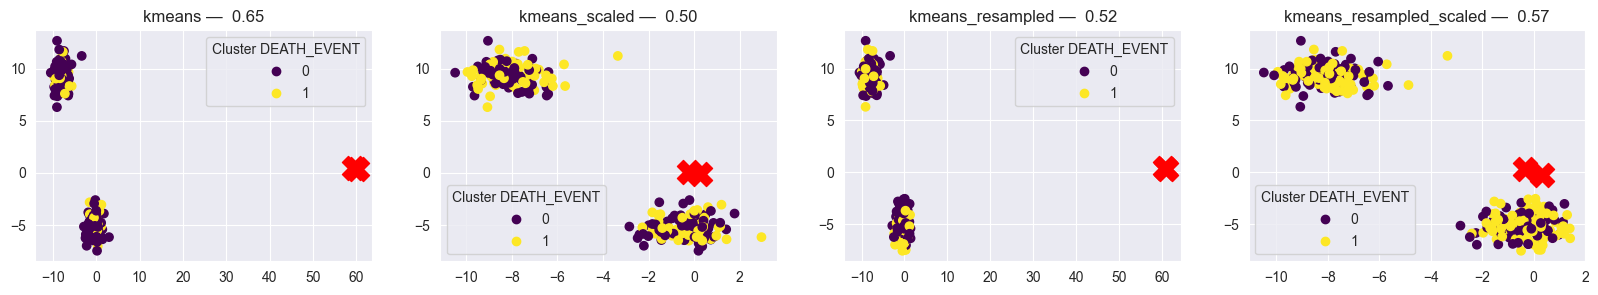

In [23]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    model = new_models[model_name].model
    X_blobs, y_blobs = make_blobs(n_samples=len(X_train if model_name.find('resampled') == -1 else X_train_resampled), centers=2, random_state=55) # sklearn.datasets
    scatter = axes[i].scatter(X_blobs[:, 0], X_blobs[:, 1], c=model.labels_, cmap='viridis', marker='o')
    axes[i].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=300, c='red', marker='X')
    axes[i].set_title(f"{model_name} —  {new_models[model_name].acc:.2f}")
    axes[i].legend(*scatter.legend_elements(), title="Cluster DEATH_EVENT")  # Cluster color legend
plt.show()

Naive-Bayes

In [24]:
naivebayes = GaussianNB()
naivebayes_scaled = GaussianNB()
naivebayes_resampled = GaussianNB()
naivebayes_resampled_scaled = GaussianNB()
new_models = dict(naivebayes=ModelMetrics(naivebayes, X_train, X_test, y_train, y_test),
        naivebayes_scaled=ModelMetrics(naivebayes_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
     naivebayes_resampled=ModelMetrics(naivebayes_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
naivebayes_resampled_scaled=ModelMetrics(naivebayes_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test))
models.update(new_models)
new_models

{'naivebayes': 
         acc: 0.7333333333333333
         cv_mean: 0.6903985507246377
         f1: 0.2898989898989899
         roc_AUC: 0.8002735978112174,
 'naivebayes_scaled': 
         acc: 0.7333333333333333
         cv_mean: 0.7072463768115942
         f1: 0.3788644688644689
         roc_AUC: 0.7838577291381669,
 'naivebayes_resampled': 
         acc: 0.8
         cv_mean: 0.665625
         f1: 0.6225056420940737
         roc_AUC: 0.7961696306429549,
 'naivebayes_resampled_scaled': 
         acc: 0.7166666666666667
         cv_mean: 0.6875
         f1: 0.613926863796429
         roc_AUC: 0.7072503419972639}

# Sort models by metrics (with weights)

In [25]:
weights = {'f1': 0.5, 'roc_AUC': 0.3, 'cv_mean': 0.2} # medical application like: f1 > roc/auc > cv_mean # todo: add thresholds (ie: a minimum f1 score)
for model_name, model in models.items():
    w_f1 = weights['f1'] if model.roc_AUC is not None else weights['f1'] + weights['roc_AUC']/2
    w_cv = weights['cv_mean'] if model.roc_AUC is not None else weights['cv_mean'] + weights['roc_AUC']/2
    model.composite_score = (w_f1 * model.f1 + weights['roc_AUC'] * (model.roc_AUC or 0) + w_cv * model.cv_mean)
[((i+1, item)) for (i, item) in enumerate(sorted(models.items(), key=lambda item: item[1].composite_score, reverse=True))]

[(1,
  ('randomforest_resampled', 
           acc: 0.7166666666666667
           cv_mean: 0.815625
           f1: 0.8169773531422138
           roc_AUC: 0.7585499316005472)),
 (2,
  ('logisticregression_resampled', 
           acc: 0.7333333333333333
           cv_mean: 0.7625
           f1: 0.7609816018497233
           roc_AUC: 0.7113543091655267)),
 (3,
  ('logisticregression_resampled_scaled', 
           acc: 0.6833333333333333
           cv_mean: 0.74375
           f1: 0.7387333301156668
           roc_AUC: 0.7099863201094391)),
 (4,
  ('naivebayes_resampled', 
           acc: 0.8
           cv_mean: 0.665625
           f1: 0.6225056420940737
           roc_AUC: 0.7961696306429549)),
 (5,
  ('decisiontree_resampled', 
           acc: 0.6666666666666666
           cv_mean: 0.7125
           f1: 0.7072444531120838
           roc_AUC: 0.5896032831737346)),
 (6,
  ('knn_resampled_scaled', 
           acc: 0.6166666666666667
           cv_mean: 0.70625
           f1: 0.69750825262783


**Best F1:** &nbsp; randomforest_resampled

**Best roc_AUC:** &nbsp; naivebayes_resampled

**Best cv_mean:** &nbsp; randomforest_resampled

## Try PCA for 1 to n-1 components on: X_train, X_train_scaled X_train_resampled_scaled

In [26]:
# stages.keys() # ['DF', 'X_train', 'X_train_resampled', 'X_train_scaled', 'X_test_scaled', 'X_train_resampled_scaled', 'X_train_minmax', 'X_test_minmax', 'X_train_resampled_minmax']
algos = dict( # (algo, args/params) tuples
    decisiontree=(DecisionTreeClassifier, dict(random_state=55)),
    randomforest=(RandomForestClassifier, dict(random_state=55, n_estimators=25, bootstrap=True)), # todo: try different n w/ pca's
    logisticregression=(linear_model.LogisticRegression, dict(random_state=55, max_iter=10000)),
    knn=(KNeighborsClassifier, dict(n_neighbors=3, weights='uniform')), # todo: try different n w/ pca's
    kmeans=(KMeans, dict(random_state=55, n_clusters=2)),
    naivebayes=(GaussianNB, dict())
)
pcas = dict()

def get_stage(stage_key): # DF|X|Y => '',  X_train => '_train',  X_train_resampled => '_train_resampled',  etc.
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

def get_y_stage(stage_key): # same as above
    stage_key = stage_key.replace('_scaled', '').replace('_minmax', '') # but: you don't scale y's
    if stage_key == 'DF' or stage_key == 'X' or stage_key == 'y': return ''
    return stage_key[1:]

for algo_key, algo in algos.items():
    for num_fts in range(1, len(X.columns)):
        for stage_key, stage in stages.items():
            if stage_key.startswith('y') or stage_key.find("_test") != -1 or get_stage(stage_key) == '': continue # don't train on _test's, y's, or stageless (overfit from training & testing on same)
            pca_key = f"{algo_key}{get_stage(stage_key)}_{num_fts}"
            pcas[pca_key] = dict(pca=PCA(n_components=num_fts),)
            pcas[pca_key]["stage"] = pcas[pca_key]["pca"].fit_transform(stage) # PCA sub-stage/dataframe
            test_stage_key = f"{stage_key.replace('_train', '_test').replace('_resampled', '')}"
            pcas[pca_key]["test_stage"] = pcas[pca_key]["pca"].transform(stages[test_stage_key]) # PCA sub-stage/dataframe   ——you don't resample testing (don't test synthetic)
            pcas[pca_key]["model"] = ModelMetrics(algo[0](**algo[1]), pcas[pca_key]["stage"], pcas[pca_key]["test_stage"], stages[f"y{get_y_stage(stage_key)}"], stages[f"y{test_stage_key.replace('DF', 'x').replace('_scaled', '').replace('_minmax', '')[1:]}"])

generates
```
pcas["kmeans_train_resampled_scaled_9"]["model"].predictions
pcas["decisiontree_8"]["pca"].components_
pcas["randomforest_train_10]["pca"].explained_variance_
```
etc.

# Sort pca-models by metrics (with weights)

In [27]:
tmp = {}
for model_name in pcas:
    model = pcas[model_name]["model"]
    w_f1 = weights['f1'] if model.roc_AUC is not None else weights['f1'] + weights['roc_AUC']/2
    w_cv = weights['cv_mean'] if model.roc_AUC is not None else weights['cv_mean'] + weights['roc_AUC']/2
    model.composite_score = (w_f1 * model.f1 + weights['roc_AUC'] * (model.roc_AUC or 0) + w_cv * model.cv_mean)
    tmp[model_name] = model
[((i+1, item)) for (i, item) in enumerate(sorted(tmp.items(), key=lambda item: item[1].composite_score, reverse=True))]

[(1,
  ('randomforest_train_resampled_10', 
           acc: 0.6666666666666666
           cv_mean: 0.784375
           f1: 0.7918164669019137
           roc_AUC: 0.7694938440492476)),
 (2,
  ('randomforest_train_resampled_7', 
           acc: 0.7166666666666667
           cv_mean: 0.796875
           f1: 0.7971330887263622
           roc_AUC: 0.7428180574555403)),
 (3,
  ('randomforest_train_resampled_9', 
           acc: 0.75
           cv_mean: 0.771875
           f1: 0.7778625680042286
           roc_AUC: 0.7482900136798906)),
 (4,
  ('randomforest_train_resampled_scaled_9', 
           acc: 0.7333333333333333
           cv_mean: 0.76875
           f1: 0.755139507874573
           roc_AUC: 0.7749658002735978)),
 (5,
  ('randomforest_train_resampled_6', 
           acc: 0.65
           cv_mean: 0.765625
           f1: 0.7750478539129327
           roc_AUC: 0.7291381668946648)),
 (6,
  ('randomforest_train_resampled_minmax_9', 
           acc: 0.6333333333333333
           cv_mean: 0.

As expected, the PCA models are all ~less accurate for our application (medical datasets are known for low volume, highly related / low redundancy features).

# Traditional Method Results

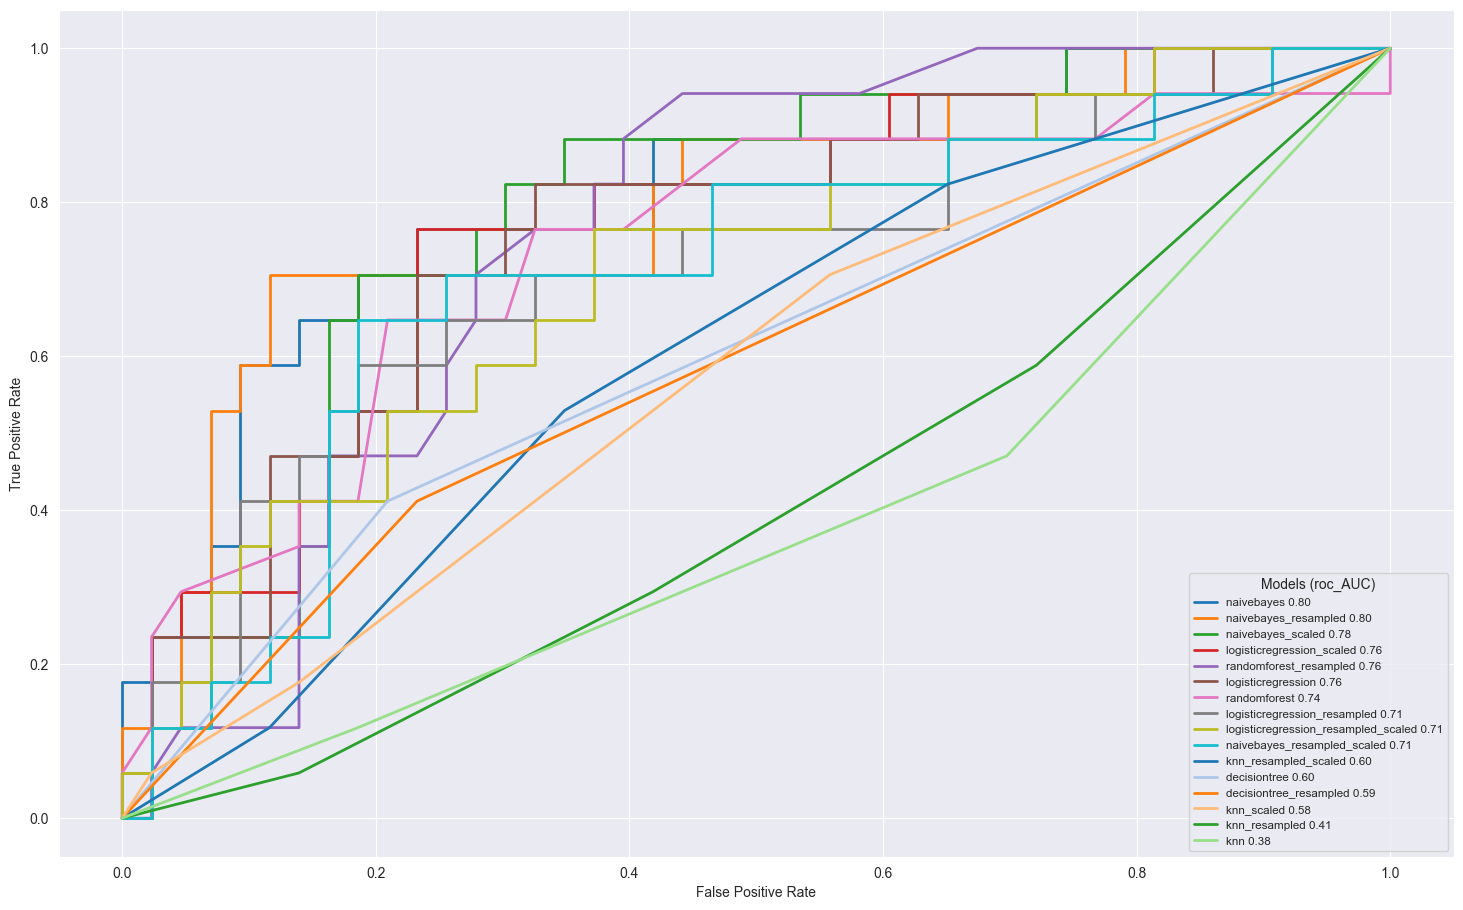

In [26]:
plt.figure(figsize=(18, 11))
distinct_colors = plt.cm.tab10.colors + plt.cm.tab20.colors
distinct_colors = distinct_colors[:len(models)]
for i, m in enumerate(sorted(models.items(), key=lambda item: item[1].roc_AUC if item[1].roc_AUC else 0, reverse=True)):
    model_name, model = m
    if models[model_name].roc_AUC is None: continue
    plt.plot(models[model_name].roc_fpr, models[model_name].roc_tpr, color=distinct_colors[i], lw=2, label=f"{model_name} {models[model_name].roc_AUC:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best', fontsize='small', title='Models (roc_AUC)')
plt.show()

# New Methods (ANN, SVM, CNN, Ensemble)

### Shallow ANN: Multi-Layer-Perceptron (MLP) via scikitlearn

In [27]:
mlp = MLPClassifier(hidden_layer_sizes=(2,), max_iter=5000, random_state=55)
mlp_scaled = MLPClassifier(hidden_layer_sizes=(2,2,1,), max_iter=5000, random_state=55)
mlp_resampled = MLPClassifier(hidden_layer_sizes=(2,), max_iter=5000, random_state=55)
mlp_resampled_scaled = MLPClassifier(hidden_layer_sizes=(2,4,1,), max_iter=5000, random_state=55)
mlp_minmax = MLPClassifier(hidden_layer_sizes=(4,3,), max_iter=5000, random_state=55)
mlp_resampled_minmax = MLPClassifier(hidden_layer_sizes=(4,3,4,), max_iter=5000, random_state=55)
new_models = dict(        mlp=ModelMetrics(mlp, X_train, X_test, y_train, y_test),
                  mlp_scaled=ModelMetrics(mlp_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
               mlp_resampled=ModelMetrics(mlp_resampled, X_train_resampled, X_test, y_train_resampled, y_test),
        mlp_resampled_scaled=ModelMetrics(mlp_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test),
                  mlp_minmax=ModelMetrics(mlp_minmax, X_train_minmax, X_test_minmax, y_train, y_test),
        mlp_resampled_minmax=ModelMetrics(mlp_resampled_minmax, X_train_resampled_minmax, X_test_minmax, y_train_resampled, y_test))

# param_grid = {
# 'hidden_layer_sizes': (
#         [(i,) for i in range(1, 5)] +  # 1 hidden layer
#         [(i, j) for i in range(1, 5) for j in range(1, 5)] +  # 2 hidden layers
#         [(i, j, k) for i in range(1, 5) for j in range(1, 5) for k in range(1, 5)]  # 3 hidden layers
#     )
# }
# grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
# grid_search.fit(X_train_minmax, y_train)
# print("Best parameters:", grid_search.best_params_, "\nBest cross-validation score:", grid_search.best_score_)

models.update(new_models)
new_models

{'mlp': 
         acc: 0.2833333333333333
         cv_mean: 0.33043478260869563
         f1: 0.4966666666666667
         roc_AUC: 0.5,
 'mlp_scaled': 
         acc: 0.7666666666666667
         cv_mean: 0.757608695652174
         f1: 0.5893123543123543
         roc_AUC: 0.6183310533515731,
 'mlp_resampled': 
         acc: 0.2833333333333333
         cv_mean: 0.5
         f1: 0.6666666666666667
         roc_AUC: 0.5,
 'mlp_resampled_scaled': 
         acc: 0.6666666666666666
         cv_mean: 0.765625
         f1: 0.7606648647343374
         roc_AUC: 0.6518467852257182,
 'mlp_minmax': 
         acc: 0.7333333333333333
         cv_mean: 0.7028985507246377
         f1: 0.23805194805194801
         roc_AUC: 0.7209302325581396,
 'mlp_resampled_minmax': 
         acc: 0.7166666666666667
         cv_mean: 0.746875
         f1: 0.7400356519004527
         roc_AUC: 0.7168262653898768}

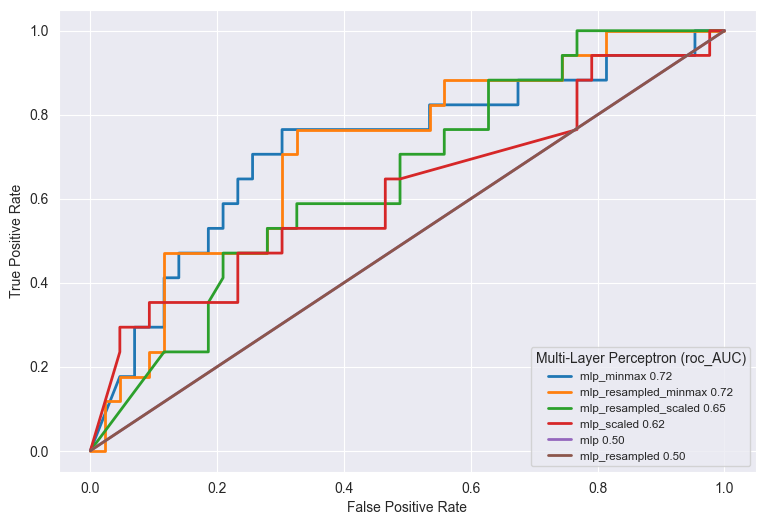

In [28]:
plt.figure(figsize=(9, 6))
for i, m in enumerate(sorted(new_models.items(), key=lambda item: item[1].roc_AUC if item[1].roc_AUC else 0, reverse=True)):
    model_name, model = m
    if new_models[model_name].roc_AUC is None: continue
    plt.plot(new_models[model_name].roc_fpr, new_models[model_name].roc_tpr, color=distinct_colors[i], lw=2, label=f"{model_name} {new_models[model_name].roc_AUC:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best', fontsize='small', title='Multi-Layer Perceptron (roc_AUC)')
plt.show()

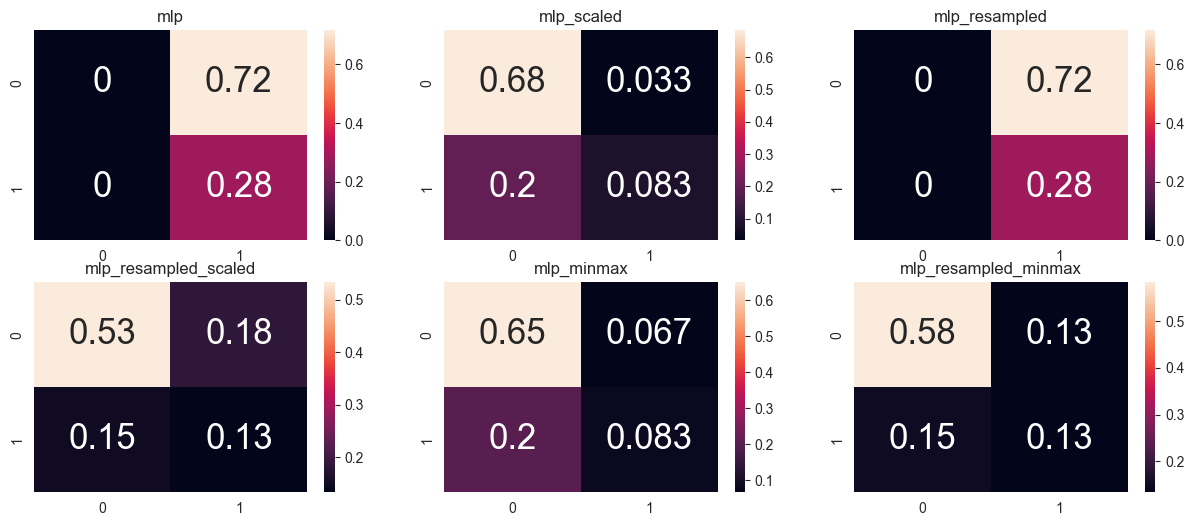

In [29]:
# confusion matrix
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    cf_matrix = metrics.confusion_matrix(y_test, models[model_name].predictions)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), ax=axes[i//3, i % 3], annot=True, annot_kws={'size':25})
    axes[i//3, i % 3].set_title(model_name)
plt.show()

### ANN: Deep learning (Keras)

In [59]:
early_stopping = EarlyStopping(min_delta=0.001, # minimium amount of change to count as an improvement
    patience=80, # how many epochs to wait before stopping
    restore_best_weights=True)
model = Sequential()
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=11))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

/Users/super/Library/Caches/pypoetry/virtualenvs/notebook-playground-15lMjr8f-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
from keras.api.metrics import AUC
def clone_sequential(m):
    seq = Sequential()
    for layer in m.layers: seq.add(layer.__class__(**layer.get_config()))
    return seq

new_models = dict(
    ann=ModelMetrics(clone_sequential(model), X_train, X_test, y_train, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                 fit=dict(batch_size=25, epochs=40, validation_split=.25, callbacks=early_stopping))), # class_weight lets know of testing imbalance
    ann_scaled=ModelMetrics(clone_sequential(model), X_train_scaled, X_test_scaled, y_train, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                 fit=dict(batch_size=25, epochs=160, validation_split=.25, callbacks=early_stopping))),
    ann_resampled=ModelMetrics(clone_sequential(model), X_train_resampled, X_test, y_train_resampled, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                 fit=dict(batch_size=25, epochs=40, validation_split=.25, callbacks=early_stopping))),
    ann_resampled_scaled=ModelMetrics(clone_sequential(model), X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                 fit=dict(batch_size=25, epochs=40, validation_split=.25, callbacks=early_stopping))),
    ann_minmax=ModelMetrics(clone_sequential(model), X_train_minmax, X_test_minmax, y_train, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                 fit=dict(batch_size=25, epochs=40, validation_split=.25, callbacks=early_stopping))),
    ann_resampled_minmax=ModelMetrics(clone_sequential(model), X_train_resampled_minmax, X_test_minmax, y_train_resampled, y_test,
                            dict(compile=dict(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()]),
                                fit=dict(batch_size=25, epochs=40, validation_split=.25, callbacks=early_stopping)))
)

# param_grid = {
# 'hidden_layer_sizes': (
#         [(i,) for i in range(1, 5)] +  # 1 hidden layer
#         [(i, j) for i in range(1, 5) for j in range(1, 5)] +  # 2 hidden layers
#         [(i, j, k) for i in range(1, 5) for j in range(1, 5) for k in range(1, 5)]  # 3 hidden layers
#     )
# }
# grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
# grid_search.fit(X_train_minmax, y_train)
# print("Best parameters:", grid_search.best_params_, "\nBest cross-validation score:", grid_search.best_score_)

models.update(new_models)
new_models

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - auc_13: 0.5172 - loss: 1.2356 - val_auc_13: 0.5331 - val_loss: 0.6217
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc_13: 0.5440 - loss: 0.7038 - val_auc_13: 0.5317 - val_loss: 0.6360
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc_13: 0.5127 - loss: 0.6497 - val_auc_13: 0.5245 - val_loss: 0.6324
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc_13: 0.5770 - loss: 0.6568 - val_auc_13: 0.5245 - val_loss: 0.6523
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_13: 0.5427 - loss: 0.6578 - val_auc_13: 0.5278 - val_loss: 0.6394
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc_13: 0.5300 - loss: 0.6574 - val_auc_13: 0.5225 - val_loss: 0.6495
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_13: 0.6241 - loss: 0.6341 - val_auc_13: 0.5298 - val_loss: 0.6309
Epoch 8/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc_13: 0.5203 - loss: 0.6602 - val_auc_13: 0.5172 - val_loss: 0.6275
Epoch 9/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

{'ann': 
         acc: 0.7166666666666667
         cv_mean: None
         f1: None
         roc_AUC: 0.5102599179206566,
 'ann_scaled': 
         acc: 0.75
         cv_mean: None
         f1: None
         roc_AUC: 0.7578659370725034,
 'ann_resampled': 
         acc: 0.7166666666666667
         cv_mean: None
         f1: None
         roc_AUC: 0.5034199726402189,
 'ann_resampled_scaled': 
         acc: 0.7166666666666667
         cv_mean: None
         f1: None
         roc_AUC: 0.5157318741450069,
 'ann_minmax': 
         acc: 0.7166666666666667
         cv_mean: None
         f1: None
         roc_AUC: 0.6593707250341998,
 'ann_resampled_minmax': 
         acc: 0.7166666666666667
         cv_mean: None
         f1: None
         roc_AUC: 0.43365253077975374}

Our dataset is too small for deep learning. Only ann_scaled could reliably predict some DEATH_EVENT=1.

In [65]:
for i in new_models: print(i, metrics.classification_report(y_test, new_models[i].predictions, zero_division=0), new_models[i].predictions.flatten(), "\n\n--------------------\n")

ann               precision    recall  f1-score   support

           0       0.72      1.00      0.83        43
           1       0.00      0.00      0.00        17

    accuracy                           0.72        60
   macro avg       0.36      0.50      0.42        60
weighted avg       0.51      0.72      0.60        60
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

--------------------

ann_scaled               precision    recall  f1-score   support

           0       0.78      0.91      0.84        43
           1       0.60      0.35      0.44        17

    accuracy                           0.75        60
   macro avg       0.69      0.63      0.64        60
weighted avg       0.73      0.75      0.73        60
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1] 

--------------------

ann_resampled               precision

#### Training and Validation loss

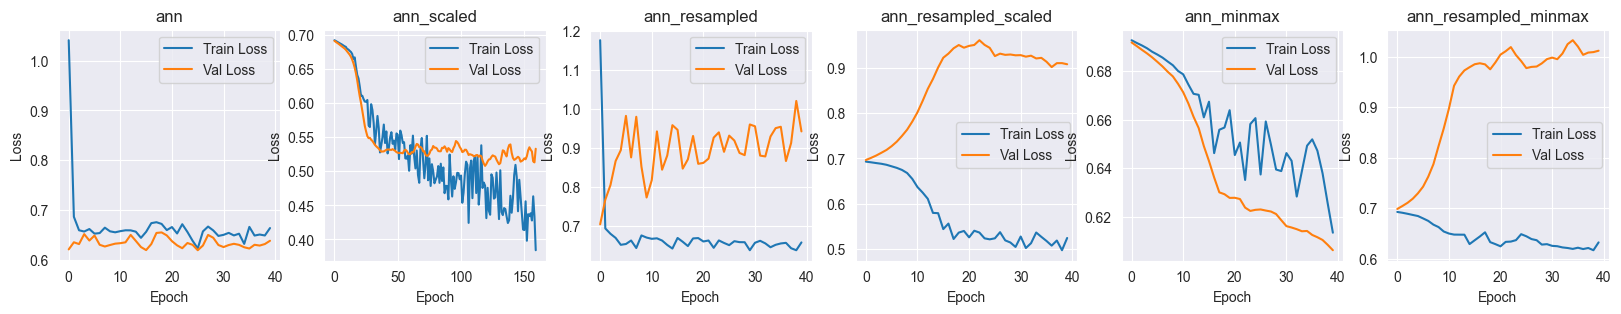

In [66]:
fig, axes = plt.subplots(1, 6, figsize=(20, 3))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    model = models[model_name]
    history = model.history
    axes[i].plot(history.history['loss'], label='Train Loss')
    axes[i].plot(history.history['val_loss'], label='Val Loss')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend(loc="best")
    print("")
plt.show()

### Training and Validation accuracy

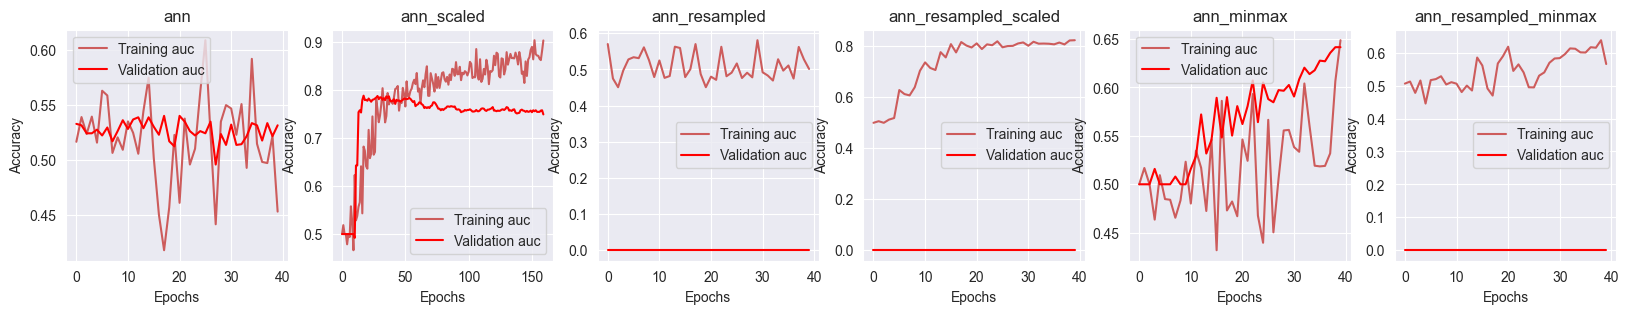

ann - 0.5266865074634552
ann_scaled - 0.7460441345348954
ann_resampled - 0.0
ann_resampled_scaled - 0.0
ann_minmax - 0.5672288417816163
ann_resampled_minmax - 0.0


In [91]:
fig, axes = plt.subplots(1, 6, figsize=(20, 3))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    model = models[model_name]
    history = model.history
    auc_key = [key for key in history.history.keys() if key.startswith('auc_')]
    if len(auc_key):
        axes[i].plot(history.history[auc_key[0]], "#CD5C5C", label='Training auc')
        axes[i].plot(history.history['val_'+auc_key[0]], "#FF0000", label='Validation auc')
    else:
        axes[i].plot(history.history['accuracy'], "#CD5C5C", label='Training accuracy')
        axes[i].plot(history.history['val_accuracy'], "#FF0000", label='Validation accuracy')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend(loc="best")
plt.show()
for i in new_models:
    auc_key = [key for key in new_models[i].history.history.keys() if key.startswith('auc_')]
    if len(auc_key): print(i, '-', np.mean(new_models[i].history.history['val_'+auc_key[0]]))
    else: print(i, '-', np.mean(new_models[i].history.history['val_accuracy']))

### confusion matrix

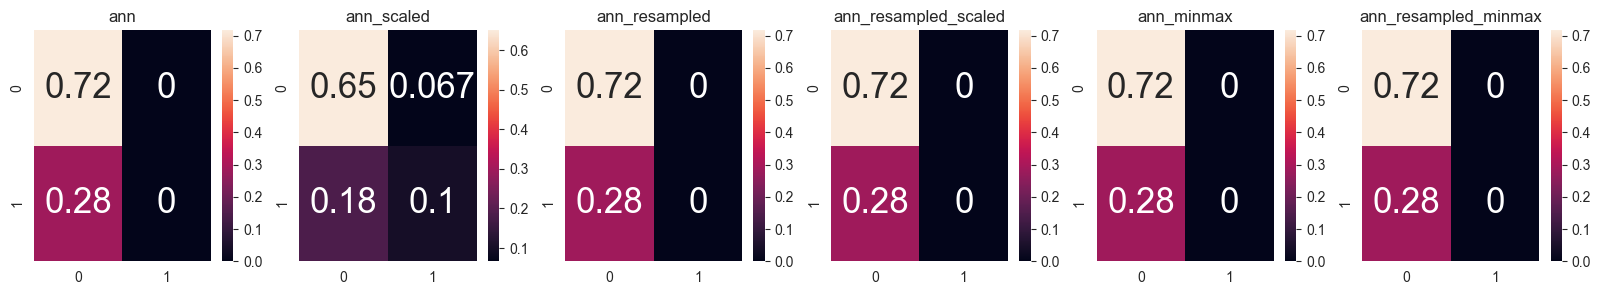

In [92]:
fig, axes = plt.subplots(1, 6, figsize=(20, 3))  # 1 row, 2 columns
for i, model_name in enumerate(new_models):
    model = models[model_name]
    cf_matrix = metrics.confusion_matrix(y_test, model.predictions)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), ax=axes[i], annot=True, annot_kws={'size':25})
    axes[i].set_title(model_name)
plt.show()

## SVM
```
defaults:   kernel='rbf',  class_weight=None,  C=1,  degree=3,  gamma='scale'
options:    kernel: ('linear', 'poly', 'sigmoid'),  class_weight: ('balanced', eg: dict(0=1, 1=2)),  gamma: or kernel coefficient ('auto', float)
```

In [93]:
# svm = SVC(kernel='linear', class_weight=None, C=5, degree=2) # scaling is essential (especially for grid search to finish)
svm_scaled = SVC(kernel='linear', class_weight=None, C=5, degree=2)
# svm_resampled = SVC(kernel='poly', class_weight=None, C=10, degree=3)
svm_resampled_scaled = SVC(kernel='poly', class_weight=None, C=0.3, degree=3)
# svm_minmax = SVC(kernel='linear', class_weight=None, C=100, degree=2)
# svm_resampled_minmax = SVC(kernel='linear', class_weight=None, C=10, degree=2)
new_models = dict(svm_scaled=ModelMetrics(svm_scaled, X_train_scaled, X_test_scaled, y_train, y_test),
        svm_resampled_scaled=ModelMetrics(svm_resampled_scaled, X_train_resampled_scaled, X_test_scaled, y_train_resampled, y_test),
                  # svm_minmax=ModelMetrics(svm_minmax, X_train_minmax, X_test_minmax, y_train, y_test),
        # svm_resampled_minmax=ModelMetrics(svm_resampled_minmax, X_train_resampled_minmax, X_test_minmax, y_train_resampled, y_test)
)

# param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'class_weight': [None, 'balanced'], 'C': [0.1, 0.2, 0.3, 0.5, 0.7, 1, 2, 5, 10, 100], 'degree': [2, 3, 4]}
# grid_search = GridSearchCV(svm_resampled_scaled, param_grid, cv=5, n_jobs=-1, verbose=2)
# grid_search.fit(X_train_resampled_scaled, y_train_resampled)
# print("Best parameters:", grid_search.best_params_, "\nBest cross-validation score:", grid_search.best_score_)

models.update(new_models)
new_models

{'svm_scaled': 
         acc: 0.75
         cv_mean: 0.7661231884057972
         f1: 0.5780425130425131
         roc_AUC: 0.7564979480164159,
 'svm_resampled_scaled': 
         acc: 0.7166666666666667
         cv_mean: 0.78125
         f1: 0.773438605615059
         roc_AUC: 0.7127222982216141}

We skip unscaled (as it doesn't finish). We skip minmax since StandardScaler is better for SVM.

**Confusion Matrix:** svm_resampled_scaled

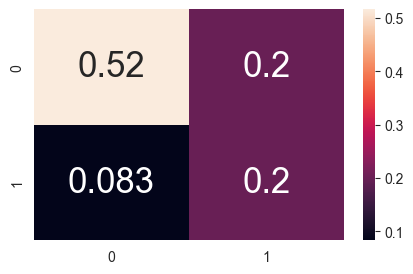

In [95]:
plt.subplots(figsize=(5,3))
cf_matrix = metrics.confusion_matrix(y_test, models["svm_resampled_scaled"].predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, annot_kws={'size':25})
plt.show()

# CNN

# Ensemble Approach (Voting, Bagging, Stacking, Boosting)

## SVM (Multiple Kernels)

In [40]:
svc_linear = SVC(kernel='linear', probability=True)
svc_rbf = SVC(kernel='rbf', probability=True)
svc_poly = SVC(kernel='poly', degree=3, probability=True)

voting_clf = VotingClassifier(estimators=[('linear', svc_linear), ('rbf', svc_rbf), ('poly', svc_poly)], voting='soft')  # Use 'soft' for probability-based voting
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

NameError: name 'VotingClassifier' is not defined

## Ensemble2

## Ensemble3